# Manual study of scaling and runtime performance

__TODO__: This needs to be converted into a python script for automatic testing.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

FONTSIZE = 16

DATAPATH = Path('..', 'sites', 'hello')

for j, fname in enumerate(DATAPATH.glob('gatherDataCpp_*_*_*_*_*_*.dat')):
    tmp_df = pd.read_csv(fname, delimiter=',', header='infer', comment='#')
    assert(len(tmp_df.NXB.unique()) == 1)
    assert(len(tmp_df.NYB.unique()) == 1)
    assert(len(tmp_df.NZB.unique()) == 1)
    assert(len(tmp_df.N_BLOCKS_X.unique()) == 1)
    assert(len(tmp_df.N_BLOCKS_Y.unique()) == 1)
    assert(len(tmp_df.N_BLOCKS_Z.unique()) == 1)
    assert(len(tmp_df.dx.unique()) == 1)
    assert(len(tmp_df.dy.unique()) == 1)
    assert(tmp_df.loc[0].dx == tmp_df.loc[0].dy)
    assert(len(tmp_df.Linf_density.unique()) == 1)
    assert(len(tmp_df.Linf_energy.unique()) == 1)

    df = tmp_df[tmp_df.pmode == 'Serial']
    assert(all(np.isnan(df.n_thd_task1)))
    assert(all(np.isnan(df.n_thd_task2)))
    assert(all(np.isnan(df.n_thd_task3)))

    df = tmp_df[tmp_df.pmode == 'Runtime']
    assert(not any(np.isnan(df.n_thd_task1)))
    assert(not any(np.isnan(df.n_thd_task2)))
    assert(not any(np.isnan(df.n_thd_task3)))

    if j == 0:
        cpp_df = tmp_df.copy()
    else:
        cpp_df = pd.concat([cpp_df, tmp_df], ignore_index=True)

for j, fname in enumerate(DATAPATH.glob('gatherDataF2003_*_*_*_*_*_*.dat')):
    tmp_df = pd.read_csv(fname, delimiter=',', header='infer', comment='#')
    assert(len(tmp_df) == 1)
    assert(tmp_df.loc[0].dx == tmp_df.loc[0].dy)

    if j == 0:
        f03_df = tmp_df.copy()
    else:
        f03_df = pd.concat([f03_df, tmp_df], ignore_index=True)

assert(len(f03_df.pmode.unique()) == 1)
assert(f03_df.loc[0].pmode == 'Runtime')
assert(not any(np.isnan(f03_df.n_thd_task1)))
assert(not any(np.isnan(f03_df.n_thd_task2)))
assert(not any(np.isnan(f03_df.n_thd_task3)))

## Second-order scaling check

__IMPORTANT__: If the test setup changes, this test needs to be reevaluated as we are manually excluding the smallest $\delta x$ from the test as error has started to dominate at that mesh spacing.

In [2]:
# Pluck out one result for each dx in the dataset
idx = []
df = cpp_df[(cpp_df.pmode == 'Serial') & (cpp_df.n_loops == 1)]
for dx in sorted(df.dx.unique()):
    idx.append( df[df.dx == dx].index[0] )
cpp_scaling_df = cpp_df.loc[idx]

# Filter out the smallest mesh size as error is dominating there
tmp_df = cpp_scaling_df[cpp_scaling_df.dx != 0.0001220703125]
fit_cpp = np.polyfit(np.log(tmp_df.dx), np.log(tmp_df.Linf_energy), 1)

tmp_df = f03_df[f03_df.dx != 0.0001220703125]
fit_f03 = np.polyfit(np.log(tmp_df.dx), np.log(tmp_df.Linf_energy), 1)

x_data = [-10, -2]

print('')
print('Fortran order of convergence\t\t{:.12f}'.format(fit_f03[0]))
print('C++     order of convergence\t\t{:.12f}'.format(fit_cpp[0]))


Fortran order of convergence		1.996073753873
C++     order of convergence		1.996073753873


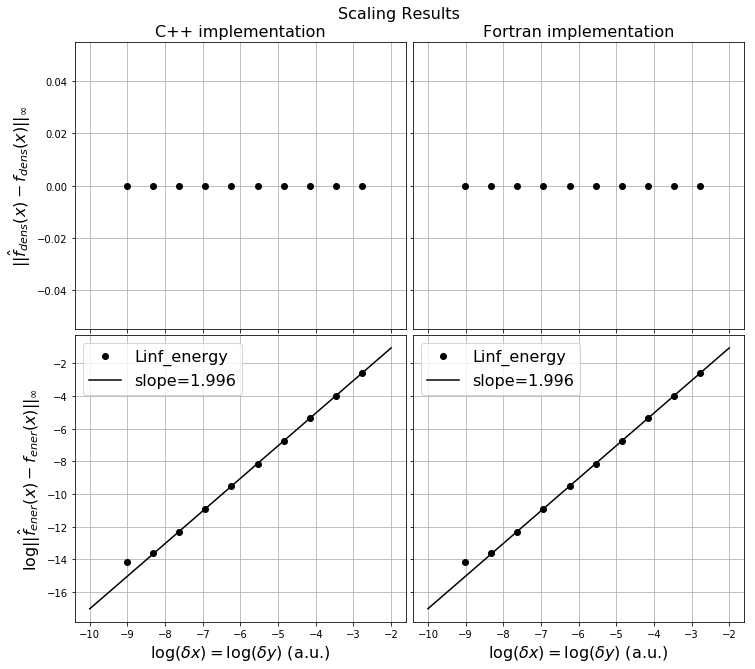

In [3]:
plt.figure(1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.02, wspace=0.02, top=0.93)
plt.suptitle('Scaling Results', fontsize=FONTSIZE)

subp = plt.subplot(221)
plt.title('C++ implementation', fontsize=FONTSIZE)
plt.plot(np.log(cpp_scaling_df.dx), cpp_scaling_df.Linf_density, 'ok')
plt.ylabel(r'$||\hat{f}_{dens}(x) - f_{dens}(x)||_{\infty}$', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_visible(False)

plt.subplot(222, sharex=subp, sharey=subp)
plt.title('Fortran implementation', fontsize=FONTSIZE)
plt.plot(np.log(f03_df.dx), f03_df.Linf_density, 'ok')
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_visible(False)
for each in plt.gca().get_yticklabels():
    each.set_visible(False)

subp2 = plt.subplot(223, sharex=subp)
plt.plot(np.log(cpp_scaling_df.dx), np.log(cpp_scaling_df.Linf_energy), 'ok')
plt.plot(x_data, np.polyval(fit_cpp, x_data), '-k', label='slope={:.3f}'.format(fit_cpp[0]))
plt.legend(fontsize=FONTSIZE)
plt.grid(True)
plt.xlabel(r'$\log(\delta x) = \log(\delta y)$ (a.u.)', fontsize=FONTSIZE)
_ = plt.ylabel(r'$\log||\hat{f}_{ener}(x) - f_{ener}(x)||_{\infty}$', fontsize=FONTSIZE)

plt.subplot(224, sharex=subp, sharey=subp2)
plt.plot(np.log(f03_df.dx), np.log(f03_df.Linf_energy), 'ok')
plt.plot(x_data, np.polyval(fit_f03, x_data), '-k', label='slope={:.3f}'.format(fit_f03[0]))
plt.legend(fontsize=FONTSIZE)
plt.grid(True)
_ = plt.xlabel(r'$\log(\delta x) = \log(\delta y)$ (a.u.)', fontsize=FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_visible(False)

## __TODO__: Add in timing analysis